In [1]:
import os
import pathlib
import splitfolders
import random 
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')


import torch
import torch.nn as nn 
from torchsummary import summary
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader
import torchvision.transforms as transforms # Thư viện xử lý ảnh
from torchvision.datasets import ImageFolder # Tải dữ liệu từ mục chứa ảnh và nhãn tương úng với chúng
from torch.optim.lr_scheduler import ReduceLROnPlateau # Kiểm soát tốc độ lr

from sklearn.metrics import confusion_matrix

from mlxtend.plotting import plot_confusion_matrix


from tqdm import tqdm # tiến trình tải dữ liệu
import warnings
warnings.filterwarnings('ignore')

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

#### Data preparation

In [2]:
# Splitting dataset to train_set, val_set and test_set
data_dir = "./OCT2017/train/"
splitfolders.ratio(data_dir, output = 'OCT_retical', seed = 20, ratio = (0.75, 0.25))

Copying files: 108309 files [11:27, 157.58 files/s]


In [3]:
data_dir = './OCT_retical/train/'
CNV = os.listdir(data_dir + '/CNV')
print("Normal: ", len(CNV))
DME = os.listdir(data_dir + '/DME')
print("Glioma: ", len(DME))
drusen = os.listdir(data_dir + '/DRUSEN')
print("Meningioma: ", len(drusen))
normal = os.listdir(data_dir + '/NORMAL')
print("Pituitary: ", len(normal))
print("All images: ", len(CNV) + len(DME) + len(drusen) + len(normal))

Normal:  27903
Glioma:  8511
Meningioma:  6462
Pituitary:  38355
All images:  81231


In [5]:
train_path = r'./OCT2017/train'
test_path = r'./OCT2017/test'
output_dir = r'.'

In [ ]:
# classes = ['NORMAL', 'CNV', 'DME', 'DRUSEN']
# num_subsets = 4
# size_for_each_subset = 4 * 1024 * 1024 * 1024  // num_subsets // len(classes)  # 1 GB per subset to 7 file

# def distribute_images(input_path, output_path, num_subsets, size_for_each_subset, classes):
#     # Create subfolders in the output directory
#     for i in range(num_subsets):
#         subset_folder = os.path.join(output_path, f'subset_{i+1}')
#         os.makedirs(subset_folder, exist_ok=True)

#         # Distribute images for each class within the subset folder
#         for class_name in classes:
#             class_path = os.path.join(input_path, class_name)
#             subset_class_folder = os.path.join(subset_folder, class_name)
#             os.makedirs(subset_class_folder, exist_ok = True)

#             # Copy images until the size limit is reached
#             current_size = 0
#             files = os.listdir(class_path)
#             random.shuffle(files)  # Shuffle to randomize image selection
#             for file in files:
#                 file_path = os.path.join(class_path, file)
#                 dest_path = os.path.join(subset_class_folder, file)
#                 file_size = os.path.getsize(file_path)

#                 if current_size + file_size <= size_for_each_subset:
#                     shutil.copy(file_path, dest_path)
#                     current_size += file_size
#                 else:
#                     break
                
# distribute_images(train_path, output_dir, num_subsets, size_for_each_subset, classes)

In [4]:
DATA_DIR_OCT = os.getcwd()
train_dir_OCT = DATA_DIR_OCT + './OCT_retical/train' # Change subset number to train on different subset
val_dir_OCT = DATA_DIR_OCT + './OCT_retical/val'

#### Image Augmentation Definitions

In [5]:
transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(degrees = 40),
    transforms.RandomHorizontalFlip(p = 0.2),
    transforms.RandomVerticalFlip(p = 0.2),
    # transforms.RandomResizedCrop(size = (128, 128), scale = (0.8, 1.0)),
    transforms.RandomAffine(degrees = 0, translate = (0.2, 0.2), shear = 0.2),
    # transforms.RandomPerspective(distortion_scale = 0.2, p = 0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])


train_data = ImageFolder(train_dir_OCT, transform = transforms)
val_data = ImageFolder(val_dir_OCT, transform = transforms)


#### Creating Dataloader

In [6]:
batch_sizes = 64
train_loader = DataLoader(train_data, batch_size = batch_sizes, shuffle = True)
val_loader = DataLoader(val_data, batch_size = batch_sizes, shuffle = True)

for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

for images, labels in val_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])
Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])


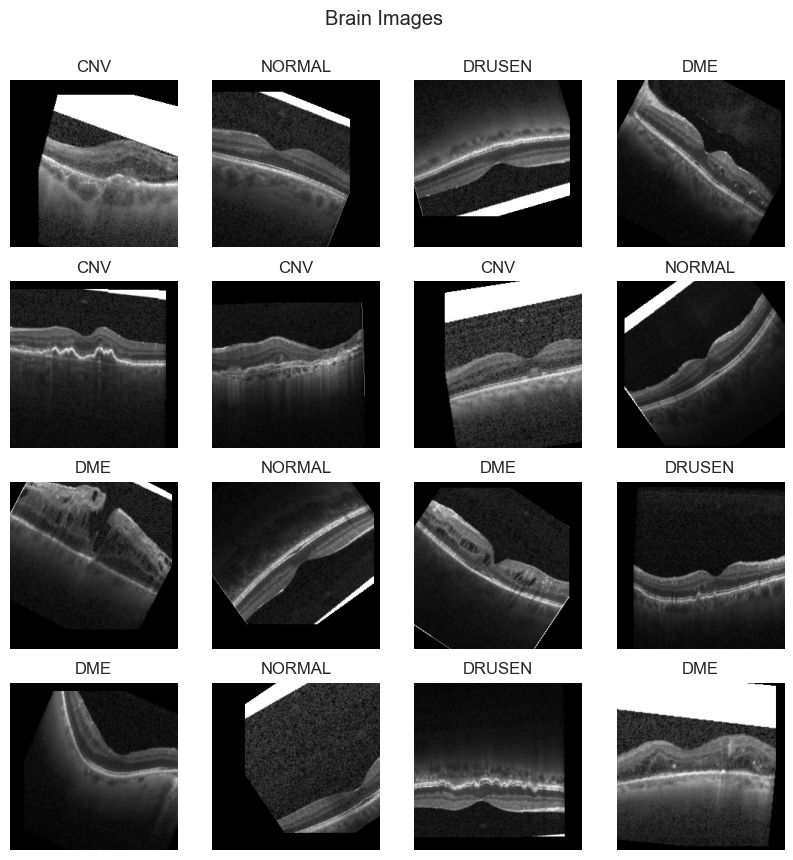

In [70]:
# Visual images from train set 
CLA_label = {
    0 : 'CNV',
    1 : 'DME',
    2 : 'DRUSEN',
    3 : 'NORMAL'
} 
figure = plt.figure(figsize = (10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(train_data))
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Brain Images', y = 0.95)
plt.show()

In [5]:
# def findConv2dOutShape(hin,win,conv,pool=2):
#     # get conv arguments
#     kernel_size = conv.kernel_size
#     stride=conv.stride
#     padding=conv.padding
#     dilation=conv.dilation

#     hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
#     wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

#     if pool:
#         hout/=pool
#         wout/=pool
#     return int(hout),int(wout)

#### Building model


In [33]:
class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x
class ResNet_18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))# giảm khích thước không gian xuống 1 vector đặc trưng duy nhất
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), # áp dụng skip connection
            Block(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )

model = ResNet_18(3,4)
summary(model,(3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,472
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─Block: 2-1                        [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          36,928
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,928
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─Block: 2-2                        [-1, 64, 56, 56]          --
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,472
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─Block: 2-1                        [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          36,928
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,928
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─Block: 2-2                        [-1, 64, 56, 56]          --
|

In [ ]:

# from torch.nn import functional as F

# class ResidualBlock(nn.Module):
    
#     def __init__(self, inchannel, outchannel, stride=1, shortcut=None):
#         super(ResidualBlock, self).__init__()
#         self.left = nn.Sequential(
#                 nn.Conv2d(inchannel, outchannel, 3, stride, 1, bias=False),# khong sử dụng bias trong quá trình học
#                 nn.BatchNorm2d(outchannel),
#                 nn.ReLU(inplace=True),
#                 nn.Conv2d(outchannel, outchannel, 3, 1, 1, bias=False),
#                 nn.BatchNorm2d(outchannel) )
#         self.right = shortcut

#     def forward(self, x):
#         out = self.left(x)
#         residual = x if self.right is None else self.right(x)
#         out += residual
#         return F.relu(out)

# class ResNet34(nn.Module):
   
#     def __init__(self, in_channels,num_classes):
#         super(ResNet34, self).__init__()
#         self.model_name = 'resnet34'

        
#         self.pre = nn.Sequential(
#                 nn.Conv2d(in_channels, 64, 7, 2, 3, bias=False),
#                 nn.BatchNorm2d(64),
#                 nn.ReLU(inplace=True),
#                 nn.MaxPool2d(3, 2, 1))
        
        
#         self.layer1 = self._make_layer( 64, 128, 3)
#         self.layer2 = self._make_layer( 128, 256, 4, stride=2)
#         self.layer3 = self._make_layer( 256, 512, 6, stride=2)
#         self.layer4 = self._make_layer( 512, 512, 3, stride=2)

        
#         self.fc = nn.Linear(512, num_classes)
    
#     def _make_layer(self,  inchannel, outchannel, block_num, stride=1):
       
#         shortcut = nn.Sequential(
#                 nn.Conv2d(inchannel,outchannel,1,stride, bias=False),
#                 nn.BatchNorm2d(outchannel))
        
#         layers = []
#         layers.append(ResidualBlock(inchannel, outchannel, stride, shortcut))
        
#         for i in range(1, block_num):
#             layers.append(ResidualBlock(outchannel, outchannel))
#         return nn.Sequential(*layers)
        
#     def forward(self, x):
#         x = self.pre(x)
        
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = F.avg_pool2d(x, 7)
#         x = x.view(x.size(0), -1)
#         return self.fc(x)

# model_34 = ResNet34(3,4)
# summary(model_34,(3,224,224))

#### Training Function


In [34]:
def train(model, train_loader, val_loader,optimizer ,criterion,num_epochs=10,patience=5):
    
    model.to(device)

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    best_val_loss = float('inf')
    counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()
                # so sánh phần tử tương ứng trong 2 tensor predicted và labels có bằng nhau hay k
                # trả về một tensor chứa các giá trị boolean
                # tính tổng các giá trị true

        val_loss /= len(val_loader)
        val_acc = correct_val / total_val

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Print the statistics
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            print(f'Early stopping triggered. No improvement in validation loss after {patience} epochs.')
            break
    print('Training finished.')
    return train_losses,train_accuracies,val_losses,val_accuracies
   

def plot_metrics(num_epochs, train_metric, val_metric, metric_name):
    epochs = np.arange(1, num_epochs + 1)
    plt.plot(epochs, train_metric, label=f'Train {metric_name}')
    plt.plot(epochs, val_metric, label=f'Validation {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.title(f'Train and Validation {metric_name} over Epochs')
    plt.legend()
    plt.show()

#  # Example usage
#     


In [35]:
# Khởi tạo các tham số
epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = 0.01)


In [36]:
train_losses,train_accuracies,val_losses,val_accuracies=train(model,train_loader,val_loader,optimizer,loss_fn,epochs)

Epoch [1/10], Train Loss: 0.6024, Train Acc: 0.7931, Val Loss: 0.6261, Val Acc: 0.7511
Epoch [2/10], Train Loss: 0.3510, Train Acc: 0.8812, Val Loss: 0.3197, Val Acc: 0.8899
Epoch [3/10], Train Loss: 0.2667, Train Acc: 0.9100, Val Loss: 0.3130, Val Acc: 0.8922
Epoch [4/10], Train Loss: 0.2236, Train Acc: 0.9256, Val Loss: 0.2248, Val Acc: 0.9264
Epoch [5/10], Train Loss: 0.2019, Train Acc: 0.9327, Val Loss: 0.2018, Val Acc: 0.9330
Epoch [6/10], Train Loss: 0.1890, Train Acc: 0.9374, Val Loss: 0.1687, Val Acc: 0.9439
Epoch [7/10], Train Loss: 0.1751, Train Acc: 0.9419, Val Loss: 0.2087, Val Acc: 0.9275
Epoch [8/10], Train Loss: 0.1667, Train Acc: 0.9453, Val Loss: 0.1755, Val Acc: 0.9456
Epoch [9/10], Train Loss: 0.1592, Train Acc: 0.9466, Val Loss: 0.2234, Val Acc: 0.9311
Epoch [10/10], Train Loss: 0.1503, Train Acc: 0.9499, Val Loss: 0.1698, Val Acc: 0.9460
Training finished.


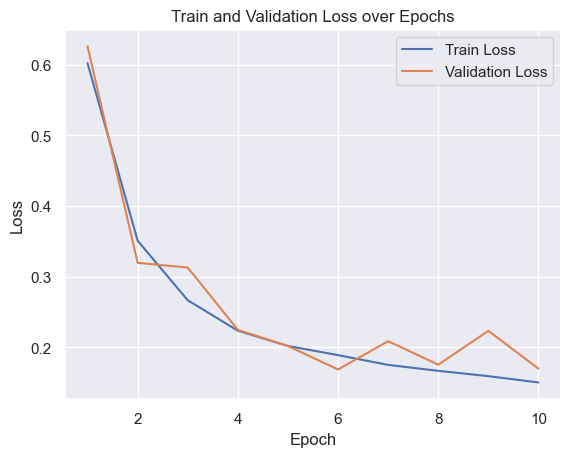

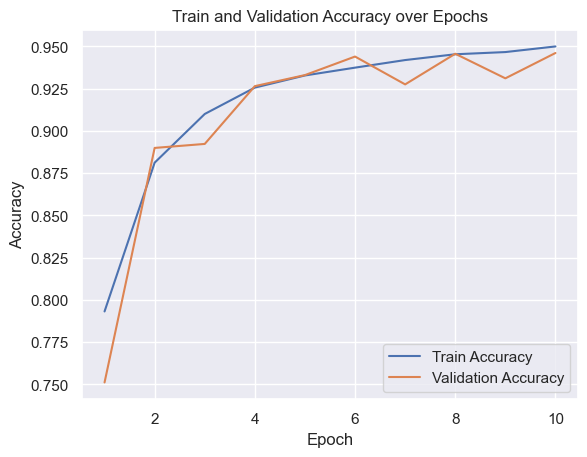

In [39]:
epochs = 10
plot_metrics(epochs, train_losses, val_losses, 'Loss')
plot_metrics(epochs, train_accuracies, val_accuracies, 'Accuracy')

Accuracy:  0.9442721028140926
Confusion matrix: 


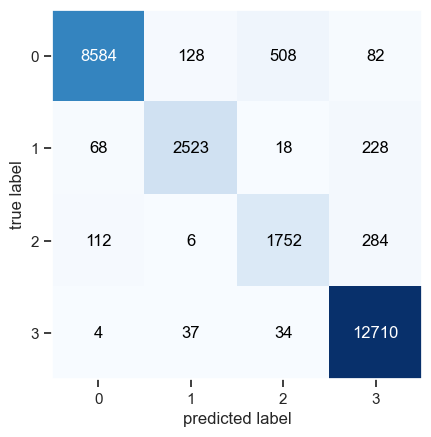

In [40]:
with torch.no_grad():
    y_pred = []
    y_true = []
    for data in val_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        y_logits = model(images)
        y_pred.extend(torch.argmax(y_logits, dim=1).cpu().numpy())
        y_true.extend(labels.cpu().numpy())
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    print("Accuracy: ", (y_pred == y_true).mean())
    print("Confusion matrix: ")
    plot_confusion_matrix(conf_mat = confusion_matrix(y_true, y_pred))
    plt.show()

#### Save model

In [41]:
# Lưu toàn bộ mô hình (bao gồm cả trạng thái của trình tối ưu hóa nếu có)
torch.save(model.state_dict(),'model_train_OCT_0,946_val.pt')
# torch.save(model,'model_train_OCT_0,934_val.pt')

    


In [42]:
from torchvision import transforms
loaded_model = ResNet_18(3,4)
loaded_model.load_state_dict(torch.load('model_train_OCT_0,934_val.pt'))
loaded_model.to(device)
loaded_model.eval()

classes=['CNV','DME','DRUSEN','NORMAL']

test_dir_OCT =  './OCT2017/test' 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
batch_sizes=32
test_data = ImageFolder(test_dir_OCT, transform=transform)
test_loader = DataLoader(test_data, batch_size=batch_sizes, shuffle=True)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = loaded_model(images)
        predicted_class_indices = torch.argmax(outputs, dim=1)
        predicted_classes = [classes[idx] for idx in predicted_class_indices]
        print(predicted_classes)
        break

['CNV', 'NORMAL', 'CNV', 'DRUSEN', 'CNV', 'NORMAL', 'DRUSEN', 'DRUSEN', 'NORMAL', 'DRUSEN', 'CNV', 'NORMAL', 'DRUSEN', 'DRUSEN', 'DME', 'CNV', 'DRUSEN', 'CNV', 'NORMAL', 'NORMAL', 'NORMAL', 'DME', 'DME', 'DRUSEN', 'DRUSEN', 'DME', 'DME', 'NORMAL', 'DME', 'CNV', 'DRUSEN', 'CNV']


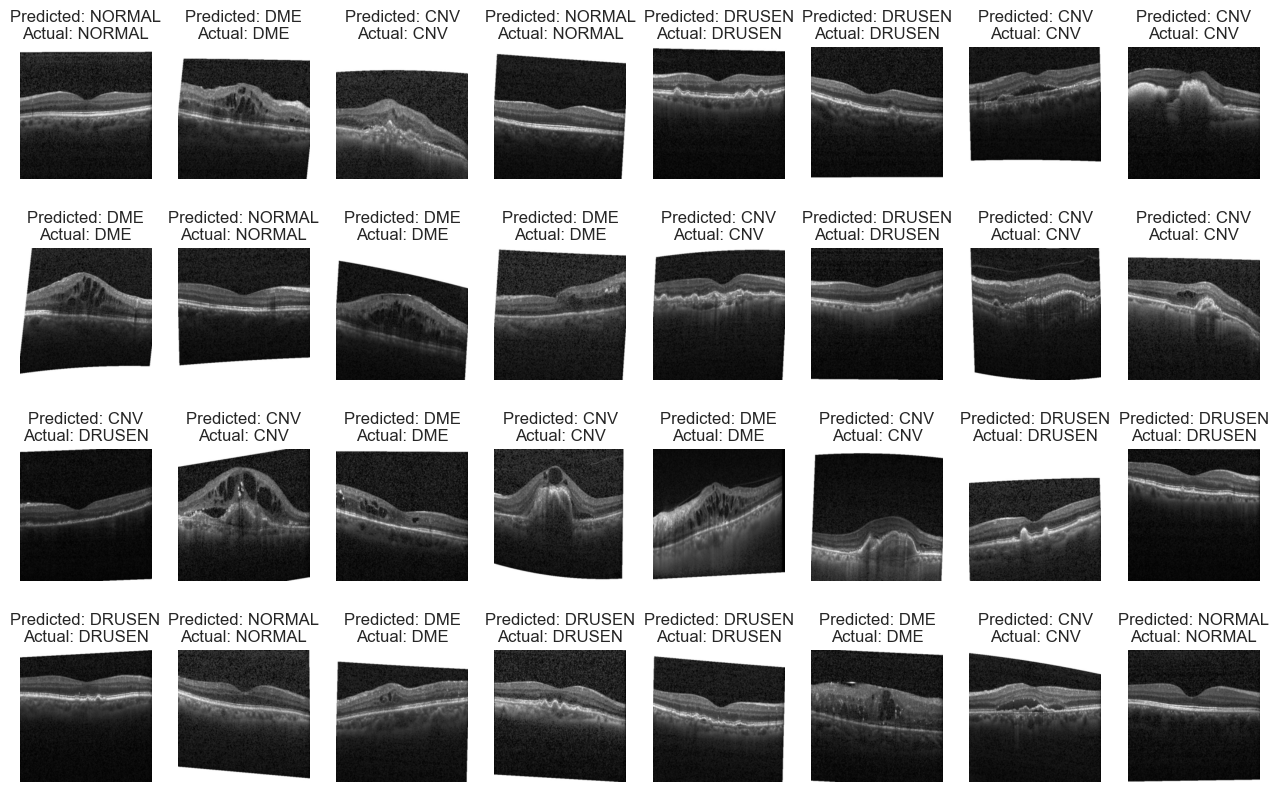

In [43]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
batch_sizes = 32
test_data = ImageFolder(test_dir_OCT, transform=transform)
test_loader = DataLoader(test_data, batch_size=batch_sizes, shuffle=True)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = loaded_model(images)
        predicted_class_indices = torch.argmax(outputs, dim=1)
        predicted_classes = [classes[idx] for idx in predicted_class_indices]
        images_cpu = images.cpu()
        # Hiển thị ảnh và nhãn dự đoán tương ứng
        fig, axs = plt.subplots(4, 8, figsize=(16, 10))
        for i in range(32):
            ax = axs[i // 8, i % 8]
            
            ax.imshow(images_cpu[i].numpy().transpose((1, 2, 0)))
            ax.set_title(f'Predicted: {predicted_classes[i]}\nActual: {classes[labels[i].item()]}')
            ax.axis('off')

        plt.show()
        break

## Ending code